In [1]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from WiSARD import WiSARD
import numpy as np
import pandas as pd
import math
import sys
import random
import matplotlib.pyplot as plt
import itertools
from Utils import thermometer,one_hot

pd.options.mode.chained_assignment = None  # default='warn'

import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt 
%matplotlib inline


from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
qtd_splits = 10
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm
from time import time
from collections import defaultdict

import itertools
#import xgboost as xgb

In [2]:
model = KeyedVectors.load_word2vec_format('../glove.6B.50d.word2vec.txt')

In [3]:
df = {
    "cooking": pd.read_csv('../dataset/processed/cooking.csv'),
    "crypto": pd.read_csv('../dataset/processed/crypto.csv'),
    "robotics": pd.read_csv('../dataset/processed/robotics.csv'),
    "biology": pd.read_csv('../dataset/processed/biology.csv'),
    "travel": pd.read_csv('../dataset/processed/travel.csv'),
    "diy": pd.read_csv('../dataset/processed/diy.csv'),
    #"physics": pd.read_csv('physics.csv'),
}

X = []
y = []
X_thermometer = []
X_onehot = []

for file in df:
    for i in range(df[file].shape[0]):
        doc = ''
        if type(df[file].iloc[i]['title']) is str:
            doc += df[file].iloc[i]['title'] + ' '
        if type(df[file].iloc[i]['content']) is str:
            doc += df[file].iloc[i]['content'] + ' '
            v = np.array([0] * 50)
            w = doc.split(' ')
            for j in w:
                if j in model:
                    v = np.add(v, model[j])
            X.append(v)
            v = v / np.linalg.norm(v) # normalized
            X_thermometer.append(thermometer(v, n=50))
            X_onehot.append(one_hot(v, n=50))
            y.append(file)
    #f = pd.DataFrame(X)
    #f.to_csv("../dataset/word2vec/" + file + ".csv", index=False)

In [4]:
l_enc = LabelEncoder()
y_enc = l_enc.fit_transform(y)
print('Encoded labels: ', list([(i, l_enc.classes_[i]) for i in range(0, len(l_enc.classes_))]))

Encoded labels:  [(0, 'biology'), (1, 'cooking'), (2, 'crypto'), (3, 'diy'), (4, 'robotics'), (5, 'travel')]


## Functions 

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
      
    plt.figure(figsize=(12,6))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.title(title + " normalized confusion matrix")
    else:
        plt.title(title + ' confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    

def benchmark(clf, X_train, y_train, X_test, y_test):

    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    
    cm = confusion_matrix(y_test, pred)  
    
    clf_descr = str(clf).split('(')[0]
    print("Done with " + clf_descr)
    print('_' * 80)
    
    return clf_descr, score, train_time, test_time, cm

def show_results(cf, name):
    print(name)
    print(cf)
    print('\n')
    print('Mean accuracy: ' + str((np.array(cf['score'])).mean()) + ' +/- ' + str((np.array(cf['score'])).std()))
    print('Mean train time: ' + str((np.array(cf['train_time'])).mean()) + ' +/- ' + str((np.array(cf['train_time'])).std()))
    print('Mean test time: ' + str((np.array(cf['test_time'])).mean()) + ' +/- ' + str((np.array(cf['test_time'])).std()))
    print('Mean confusion matrix:')
    
    t = [np.matrix(x) for x in cf['confusion_matrix']]
    su = np.matrix(t[0])
    for i in range(1,len(t)):
        su += t[i]
    plot_confusion_matrix(np.squeeze(np.asarray(su)), l_enc.classes_, title=name, normalize=True)
    
    print('_' * 80)

## Kfold

In [6]:
X_train = np.array(X)
y_train = np.array(y_enc)

kf = StratifiedKFold(n_splits=10)

#results = defaultdict(list)
resultsGaussianNB = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }
resultsBernoulliNB = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }
resultsRandomForest = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }
resultsSVM = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }
resultsWisardThermometer = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }
resultsWisardOneHot = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }


for train, test in kf.split(X_train, y_train):
    clfr = benchmark(GaussianNB(), X_train[train], y_train[train], X_train[test], y_train[test])
    resultsGaussianNB['score'].append(clfr[1])
    resultsGaussianNB['train_time'].append(clfr[2])
    resultsGaussianNB['test_time'].append(clfr[3])
    resultsGaussianNB['confusion_matrix'].append(clfr[4])

for train, test in kf.split(X_train, y_train):
    clfr = benchmark(BernoulliNB(), X_train[train], y_train[train], X_train[test], y_train[test])
    resultsBernoulliNB['score'].append(clfr[1])
    resultsBernoulliNB['train_time'].append(clfr[2])
    resultsBernoulliNB['test_time'].append(clfr[3])
    resultsBernoulliNB['confusion_matrix'].append(clfr[4])

for train, test in kf.split(X_train, y_train):
    clfr = benchmark(RandomForestClassifier(), X_train[train], y_train[train], X_train[test], y_train[test])
    resultsRandomForest['score'].append(clfr[1])
    resultsRandomForest['train_time'].append(clfr[2])
    resultsRandomForest['test_time'].append(clfr[3])
    resultsRandomForest['confusion_matrix'].append(clfr[4])

for train, test in kf.split(X_train, y_train):
    clfr = benchmark(svm.LinearSVC(), X_train[train], y_train[train], X_train[test], y_train[test])
    resultsSVM['score'].append(clfr[1])
    resultsSVM['train_time'].append(clfr[2])
    resultsSVM['test_time'].append(clfr[3])
    resultsSVM['confusion_matrix'].append(clfr[4])
    


Training: 
GaussianNB(priors=None)
train time: 0.051s
test time:  0.009s
accuracy:   0.734
Done with GaussianNB
________________________________________________________________________________
Training: 
GaussianNB(priors=None)
train time: 0.042s
test time:  0.009s
accuracy:   0.739
Done with GaussianNB
________________________________________________________________________________
Training: 
GaussianNB(priors=None)
train time: 0.043s
test time:  0.009s
accuracy:   0.756
Done with GaussianNB
________________________________________________________________________________
Training: 
GaussianNB(priors=None)
train time: 0.048s
test time:  0.009s
accuracy:   0.741
Done with GaussianNB
________________________________________________________________________________
Training: 
GaussianNB(priors=None)
train time: 0.043s
test time:  0.009s
accuracy:   0.741
Done with GaussianNB
________________________________________________________________________________
Training: 
GaussianNB(priors=None)


All results


Naïve-Bayes Gaussian
{'train_time': [0.050531625747680664, 0.04247903823852539, 0.042630910873413086, 0.04837608337402344, 0.04268145561218262, 0.042626380920410156, 0.04720044136047363, 0.04269146919250488, 0.04280996322631836, 0.050024986267089844], 'test_time': [0.009213685989379883, 0.009181976318359375, 0.009043693542480469, 0.009307861328125, 0.009208440780639648, 0.009220361709594727, 0.009437799453735352, 0.00924229621887207, 0.00979924201965332, 0.009321451187133789], 'score': [0.7343139508159043, 0.7392553435991726, 0.7560050568900126, 0.7406045282151477, 0.7411494252873563, 0.7420689655172413, 0.736061616277733, 0.728014714334981, 0.7301678546792366, 0.7260809567617296], 'confusion_matrix': [array([[1121,   71,   22,   19,   55,   32],
       [  25, 1469,    0,   29,    7,   11],
       [ 385,   10,  522,    0,   13,  114],
       [ 135,  788,    2, 1444,   24,  199],
       [ 103,    9,   26,   17,   94,   28],
       [  24,   60,   12,   69,   23, 1740]]), ar

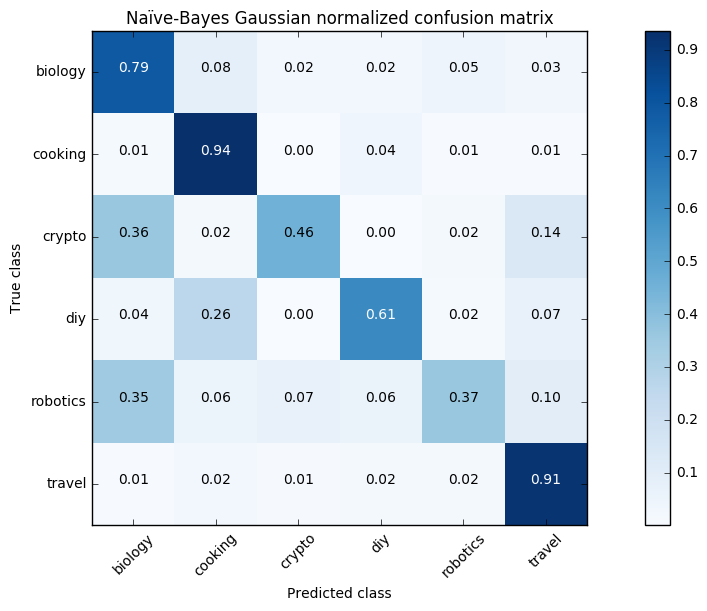

________________________________________________________________________________
Naïve-Bayes Bernoulli
{'train_time': [0.17290091514587402, 0.07599020004272461, 0.07592010498046875, 0.07927441596984863, 0.07554125785827637, 0.08293414115905762, 0.07557344436645508, 0.07559990882873535, 0.07825922966003418, 0.07576370239257812], 'test_time': [0.008623361587524414, 0.005990743637084961, 0.005909442901611328, 0.005942344665527344, 0.0059659481048583984, 0.006106138229370117, 0.005947589874267578, 0.005941152572631836, 0.006028890609741211, 0.0059926509857177734], 'score': [0.8291197425879109, 0.8411859342679844, 0.8390989541432019, 0.8467992184806344, 0.8420689655172414, 0.8488505747126437, 0.8429704563742959, 0.8442349695367284, 0.8431823407679926, 0.8452161913523459], 'confusion_matrix': [array([[1033,   68,  103,   65,   24,   27],
       [  64, 1336,    5,  112,    3,   21],
       [  65,    4,  889,   15,   24,   47],
       [  75,  157,   26, 2213,   62,   59],
       [  32,    8,  

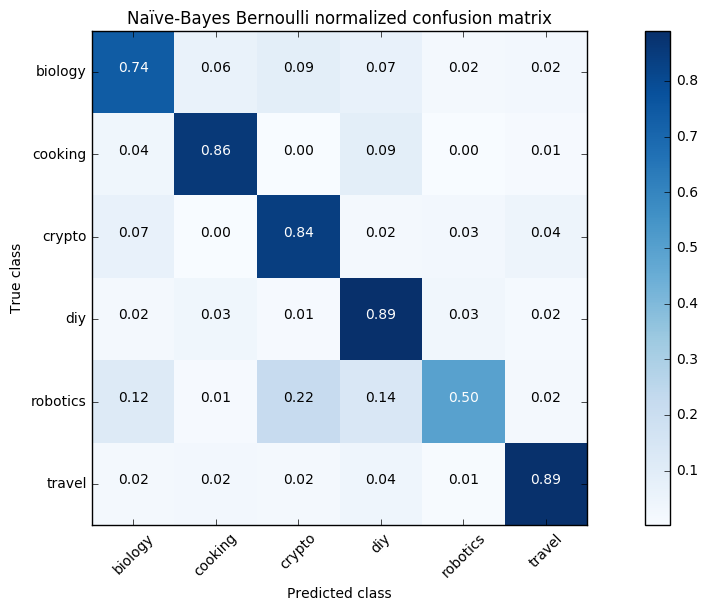

________________________________________________________________________________
Random Forest
{'train_time': [6.769571542739868, 6.91755485534668, 7.017152547836304, 6.9462058544158936, 6.558224678039551, 6.587003707885742, 6.731088399887085, 6.752492666244507, 6.938760042190552, 6.805322170257568], 'test_time': [0.017783641815185547, 0.020039081573486328, 0.020022153854370117, 0.01606011390686035, 0.015843868255615234, 0.01572108268737793, 0.019777536392211914, 0.0196688175201416, 0.019781112670898438, 0.015854597091674805], 'score': [0.8912893587680993, 0.898758905998621, 0.898517411791748, 0.8934605217791058, 0.8945977011494253, 0.9074712643678161, 0.9002184159098747, 0.9041269111392114, 0.8989422855828926, 0.9022539098436062], 'confusion_matrix': [array([[1189,   28,   47,   39,    4,   13],
       [  69, 1398,    8,   52,    1,   13],
       [  53,    3,  954,   14,    7,   13],
       [  69,   77,   32, 2351,    7,   56],
       [  44,    5,   59,   45,  117,    7],
       [  54

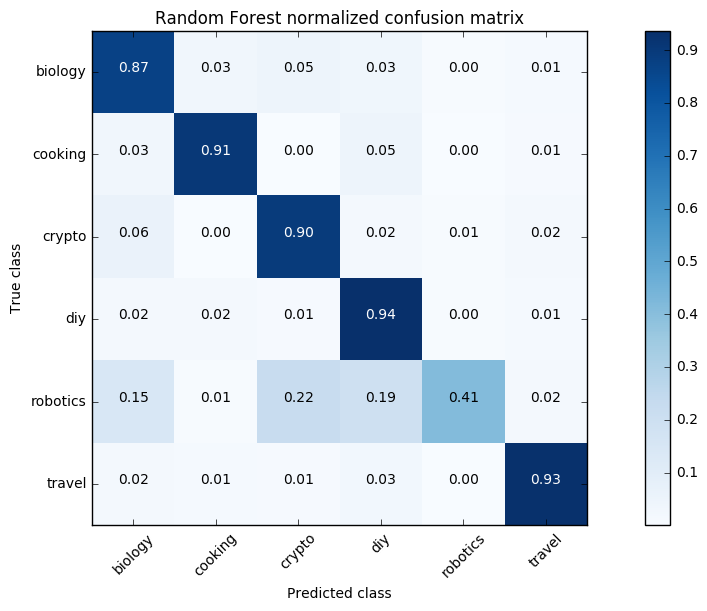

________________________________________________________________________________
SVM
{'train_time': [111.82966780662537, 111.38491320610046, 111.417888879776, 112.1553852558136, 110.56275224685669, 111.00832533836365, 108.70744109153748, 107.66396880149841, 107.73288106918335, 107.43553876876831], 'test_time': [0.0014493465423583984, 0.0014331340789794922, 0.001434326171875, 0.001451253890991211, 0.0014355182647705078, 0.0014462471008300781, 0.0013859272003173828, 0.00142669677734375, 0.001428365707397461, 0.001360177993774414], 'score': [0.9050792921167548, 0.8692254654102505, 0.9288587518676015, 0.9250660843581198, 0.8464367816091954, 0.8954022988505748, 0.9072307161742729, 0.9302218645821358, 0.937456886640607, 0.8299218031278749], 'confusion_matrix': [array([[1257,    5,    2,   51,    2,    3],
       [  60, 1280,    5,  187,    2,    7],
       [  65,    0,  932,   42,    4,    1],
       [  40,    8,    6, 2536,    0,    2],
       [  37,    0,   25,  103,  111,    1],
       [ 

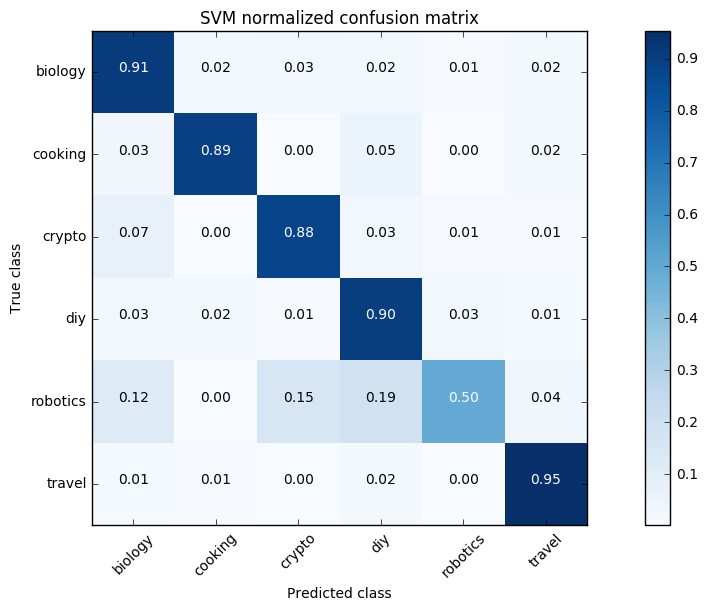

________________________________________________________________________________


In [11]:
print('All results')
print('\n')

show_results(resultsGaussianNB, 'Naïve-Bayes Gaussian')
show_results(resultsBernoulliNB, 'Naïve-Bayes Bernoulli')
show_results(resultsRandomForest, 'Random Forest')
show_results(resultsSVM, 'SVM')

In [ ]:
   
X_train = np.array(X_onehot)
for train, test in kf.split(X_train, y_train):
    clfr = benchmark(WiSARD(4, seed=random.randint(0, 2**32-1), ignore_zero_addr=True), X_train[train], y_train[train], X_train[test], y_train[test])
    resultsWisardOneHot['score'].append(clfr[1])
    resultsWisardOneHot['train_time'].append(clfr[2])
    resultsWisardOneHot['test_time'].append(clfr[3])
    resultsWisardOneHot['confusion_matrix'].append(clfr[4])

In [ ]:
#show_results(resultsWisardThermometer, 'WiSARD with Thermometer')
show_results(resultsWisardOneHot, 'WiSARD with One Hot')